In [9]:
# some tools:
import json
from functools import partial
from cjm_psl_utils.core import download_file, file_extract
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop
import math


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
import cv2 as cv
# from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.autograd import Variable
from pytorch_lightning import loggers as pl_loggers


# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.v2  as transforms

# utils to draw image with bounding box
font_file = 'Oswald-Bold.ttf'
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=15)

In [10]:
# DATA AUGMENTATIONS
TRAIN_SIZE = 256

data_aug_tfms = transforms.Compose(
    transforms=[
        CustomRandomIoUCrop(min_scale = 0.3, # minimum downscaling factor relatively to the input img; here 30%
                        max_scale = 1.0, # maximum factor
                        min_aspect_ratio = 0.5, # width cant be less than 50% of the height
                        max_aspect_ratio = 2.0, # cant be greater than 100%
                        sampler_options = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], # controlling the probability of small IoU between box and ROI
                        trials = 400, # max trial for finding suitable crop
                        jitter_factor = 0.25 # randomness variance of the paramaters
        ),
        transforms.ColorJitter( # some color shuffle
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(), 
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5), # some rotations
    ],
)

# DATA TRANSFORMATIONS
resize_pad_tfm = transforms.Compose([
    ResizeMax(max_sz = TRAIN_SIZE), 
    PadSquare(shift=True),
    transforms.Resize([TRAIN_SIZE] * 2, antialias=True)
])

# DATA TRANSFORMATIONS
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), # will normalize the pixels
    transforms.SanitizeBoundingBoxes(),
])

# GATHERING EVERYTHING
final_transforms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

In [11]:
# utils for centernet ETL

def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1 = 1
  b1 = (height + width)
  c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  # r1 = (b1 + sq1) / 2 #
  r1 = (b1 - sq1) / (2 * a1)

  a2 = 4
  b2 = 2 * (height + width)
  c2 = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  # r2 = (b2 + sq2) / 2
  r2 = (b2 - sq2) / (2 * a2)

  a3 = 4 * min_overlap
  b3 = -2 * min_overlap * (height + width)
  c3 = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3 = (b3 + sq3) / 2
  # r3 = (b3 + sq3) / (2 * a3)

  # print('DEBUG gaussian radius:', 'r1:', r1, 'r2:', r2, 'r3', r3)
  return min(r1, r2, r3)

# DEBUG gaussian radius: r1: 0.49064965930913207 r2: 0.4309534842669742 r3 1.4711701434024533
# DEBUG gaussian radius: r1: 0.5677848597182322 r2: 0.5                 r3 1.689346597454362
# DEBUG gaussian radius: r1: 0.5976076634878256 r2: 0.5274093219876037 r3 1.766922287382016
# DEBUG gaussian radius: r1: 0.5550887221618188 r2: 0.4900199203977733 r3 1.6399203184089064

def gaussian2D(shape, sigma=1):
  m, n = [(ss - 1.) / 2. for ss in shape]
  y, x = np.ogrid[-m:m + 1, -n:n + 1]

  h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
  h[h < np.finfo(h.dtype).eps * h.max()] = 0
  return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0:  # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap


# printing inputs after transformations

def print_base_img_annotated_img(img, box_xyxy, classes_id, classes_name_list):
    annotated_tensor = draw_bboxes(
        image = (img * 255).to(dtype=torch.uint8), 
        boxes = box_xyxy, 
        labels = [classes_name_list[int(c)] for c in classes_id],
    )

    img = np.transpose(np.array(img), (1, 2, 0))
    annotated_img = np.transpose(np.array(annotated_tensor), (1, 2, 0))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(f'img {img.shape}')

    axs[1].imshow(annotated_img)
    axs[1].axis('off')
    axs[1].set_title(f'annotated {annotated_img.shape}')

    plt.tight_layout()
    plt.show()

def plot_heatmap(matrix, title='no title', figsize=(8, 6)):
    # Plot the heatmap
    plt.figure(figsize=figsize) 
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Add colorbar to show the scale
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [12]:
BASE_PATH = "/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/centernet/cardDetectionDataset/"
TEST_PATH = "test/"
TRAIN_PATH = "train/"
VAL_PATH = "valid/"
ANNOTATION_FILENAME = "_annotations.coco.json"

NB_CLASS = 53

class CardDlayingDataset(Dataset):
    def __init__(self, path, transforms=None):

        self.path = path

        with open(self.path + '_annotations.coco.json', 'r') as f:
            datas = json.load(f)
        classes = datas['categories']
        imgs = datas['images']
        annotations = datas['annotations']
        
        self.parsed_datas = self._datas_parser(imgs, annotations)
        self.classes_names = [c['name'] for c in classes] # class_name are already in order

        
        self.size = len(self.parsed_datas)
        print('DEBUG classname len:', len(self.classes_names))
        self.transforms = transforms

        self.max_objs = 5
        self.padding = 127  # 31 for resnet/resdcn
        self.downsampling_ratio = 4
        self.img_size = {'h': TRAIN_SIZE, 'w': TRAIN_SIZE}
        self.fmap_size = {'h': TRAIN_SIZE // self.downsampling_ratio, 'w': TRAIN_SIZE // self.downsampling_ratio}
        # self.rand_scales = np.arange(0.6, 1.4, 0.1)
        self.gaussian_iou = 0.3


        
    def __getitem__(self, i):
        img = Image.open(self.path + self.parsed_datas[i]['filename']).convert('RGB')
        labels = self.parsed_datas[i]['labels']
        
        
        if self.transforms:
            bx = [b['box'] for b in labels] # [ [x,y,w,h], [x,y,w,h], ...]
            cid = [c['classe'] for c in labels] # [id, id, id, ..]

            # make it 'consumable' for our transformations 
            targets_data_struct = {
                'boxes': BoundingBoxes(torchvision.ops.box_convert(torch.Tensor(bx), 'xywh', 'xyxy'),
                           format='xyxy',
                           canvas_size=img.size
                           ),
                'labels': torch.Tensor(cid)
            }

            hmaps = np.zeros( (len(self.classes_names), self.fmap_size['h'], self.fmap_size['w']), dtype=np.float32 )
            offset_map = np.zeros( (self.max_objs, 2), dtype=np.float32 )
            size_map = np.zeros( (self.max_objs, 2), dtype=np.float32 )
            center_position_save = np.zeros( (self.max_objs, 2), dtype=np.float32 ) # will allow us to retrieve the good value to compare in the offset and size predicted heads 

            img, labels = self.transforms(img, targets_data_struct)

            for i, (bbox, label) in enumerate(zip(labels['boxes'], labels['labels'])):
                p = np.array([(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2]) # (x, y) coordinate of the center of the boundingbox
                p_down = (p / self.downsampling_ratio)
                p_down_int = p_down.astype(np.int32) # the downsampled centerpoint p_tilde = (p / R) from the paper
                h_down, w_down = (bbox[3] - bbox[1]) / self.downsampling_ratio, (bbox[2] - bbox[0]) / self.downsampling_ratio # height and width of the downsampled bounding box

                std = max(0, int(gaussian_radius((math.ceil(h_down), math.ceil(w_down)), self.gaussian_iou )))
                
                #   RADIUS DEBUG 
                # print('----------- >', std)
                # print('----------- > h_down', h_down)
                # print('----------- > w_down', w_down)
                # print('----------- > math.ceil(h_down)', math.ceil(h_down))
                # print('----------- > math.ceil(w_down)', math.ceil(w_down))
                # print('----------- > int(gaussian_radius((math.ceil(h_down), math.ceil(w_down)), self.gaussian_iou )) ', gaussian_radius((math.ceil(h_down), math.ceil(w_down)), self.gaussian_iou ), end='\n\n')
                
                draw_umich_gaussian(hmaps[int(label)], p_down_int, std)

                size_map[i] = torch.tensor([w_down, h_down], dtype=torch.float32)
                offset_map[i] = torch.tensor(p_down - p_down_int)
                center_position_save[i] = p_down_int
            
            return {
                'img': img,
                'labels': labels,
                'hmaps': hmaps,
                'offset_map': offset_map,
                'size_map': size_map,
                'center_position_save': center_position_save
            }
        
        return (img, labels)

    def __len__(self):
        return self.size
    
    def _datas_parser(self, imgs, annotations):
        images_list_parsed = []

        for img in imgs:
            img_id, filename = img['id'], img['file_name']
            related_annotations = []
            for annot in annotations:
                if annot["image_id"] == img_id:
                    related_annotations.append(dict( box=annot['bbox'], classe=annot['category_id'], area=annot['area']) )
            images_list_parsed.append(dict(id=img_id, filename=filename, labels=related_annotations))

        return (images_list_parsed)

In [13]:
test = CardDlayingDataset(BASE_PATH + TRAIN_PATH, transforms=final_transforms)

DEBUG classname len: 53


In [14]:
sample_test = test[0]

In [15]:
print(sample_test.keys())


dict_keys(['img', 'labels', 'hmaps', 'offset_map', 'size_map', 'center_position_save'])


<class 'torchvision.tv_tensors._image.Image'> <class 'dict'> torch.float32 torch.float32


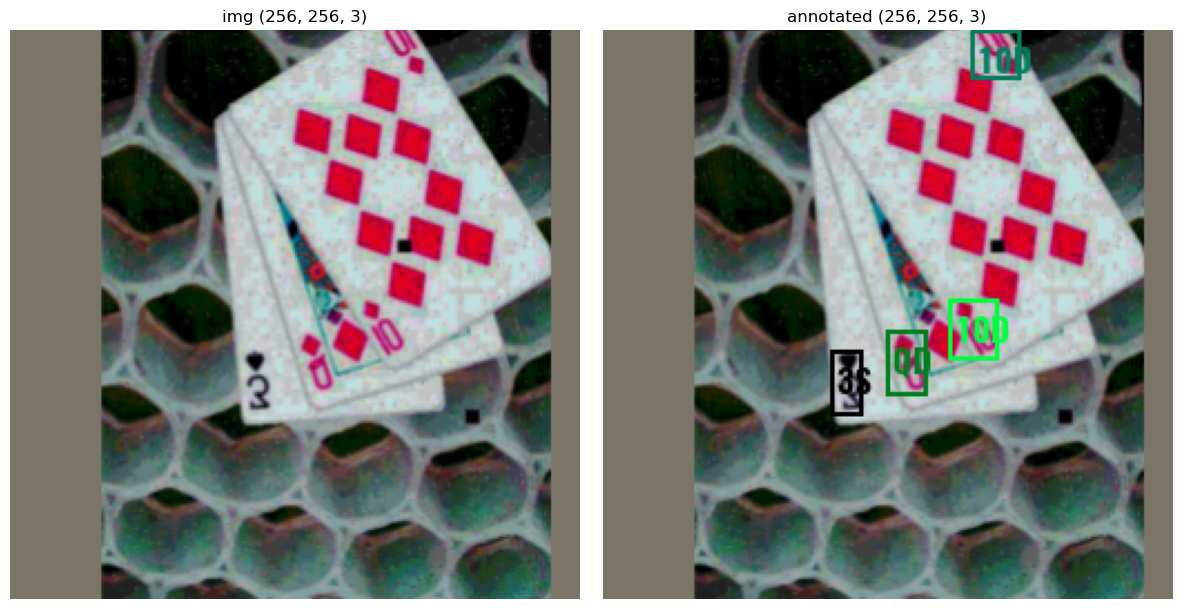

In [16]:
img, labels = sample_test['img'], sample_test['labels']
print(type(img), type(labels), (labels['boxes'].dtype), (labels['labels'].dtype))
print_base_img_annotated_img(img, labels['boxes'], labels['labels'], test.classes_names)

In [17]:
# the heatmaps

hmaps = sample_test['hmaps']

print('DEBUG: hmaps.shape:', hmaps.shape, 'type(hmaps):', type(hmaps))


classes_id = labels['labels']

print(classes_id)
print(classes_id.to(torch.int8))
print([test.classes_names[int(id)] for id in classes_id])

print('so, if i got this right, only hmaps at indices', classes_id.to(torch.int8), 'should be filled with heatmaps')

DEBUG: hmaps.shape: (53, 64, 64) type(hmaps): <class 'numpy.ndarray'>
tensor([12., 50.,  2.,  2.])
tensor([12, 50,  2,  2], dtype=torch.int8)
['3S', 'QD', '10D', '10D']
so, if i got this right, only hmaps at indices tensor([12, 50,  2,  2], dtype=torch.int8) should be filled with heatmaps


tensor(12, dtype=torch.int8)


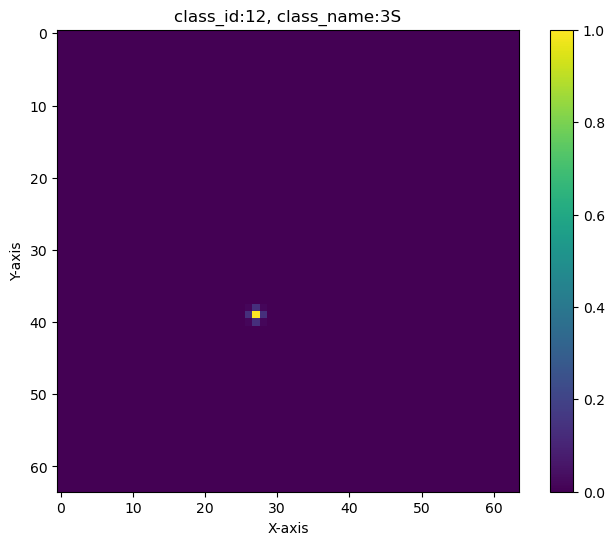

tensor(50, dtype=torch.int8)


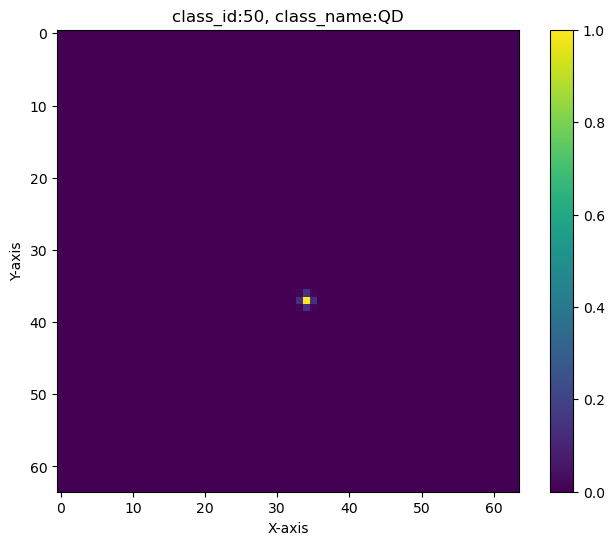

tensor(2, dtype=torch.int8)


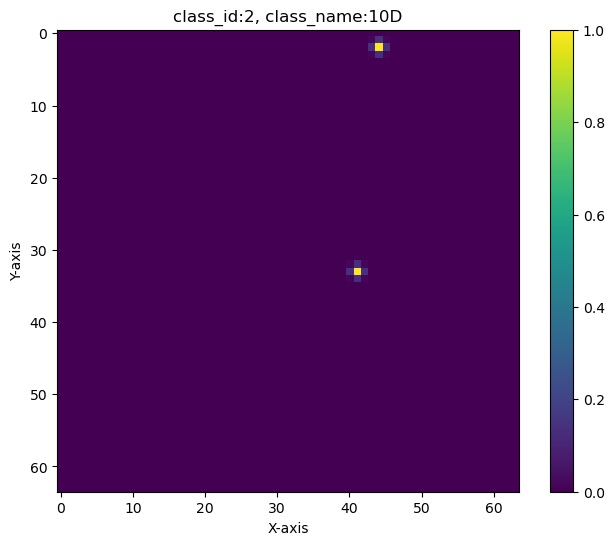

tensor(2, dtype=torch.int8)


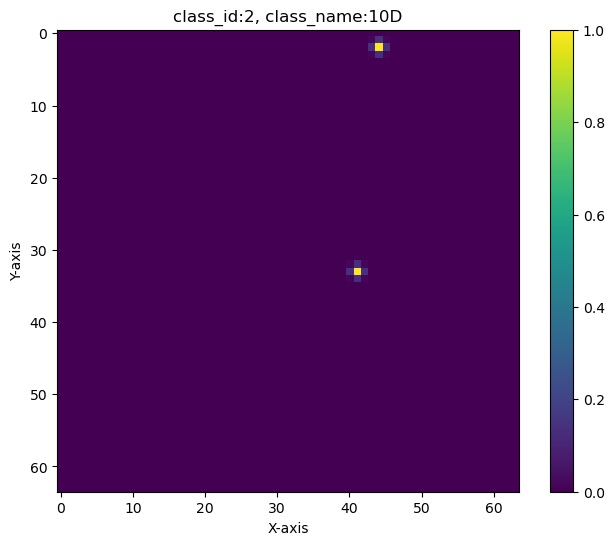

In [18]:

for i, class_id in enumerate( (classes_id.to(torch.int8)) ):
    print(class_id)
    plot_heatmap(hmaps[int(class_id)], f'class_id:{class_id}, class_name:{test.classes_names[class_id]}', (8, 6))


In [19]:
# printing the sizes and the offsets

o = sample_test['offset_map']
s = sample_test['size_map']

for i, class_id in enumerate( (classes_id.to(torch.int8)) ):
    offset = o[i]
    size = s[i]

    print(f'class_id:{class_id}, class_name:{test.classes_names[class_id]}')
    print(f'original bbox size: (w = {labels['boxes'][i][2] - labels['boxes'][i][0]}, h = {labels['boxes'][i][3] - labels['boxes'][i][1]})')
    print(f'downsampled bbox size: (w = {size[0]}, h = {size[1]})')
    print(f'offset: (w = {offset[0]}, h = {offset[1]})', end='\n\n\n')



class_id:12, class_name:3S
original bbox size: (w = 13.246498107910156, h = 28.640274047851562)
downsampled bbox size: (w = 3.311624526977539, h = 7.160068511962891)
offset: (w = 0.4002494812011719, h = 0.710845947265625)


class_id:50, class_name:QD
original bbox size: (w = 17.661972045898438, h = 28.640274047851562)
downsampled bbox size: (w = 4.415493011474609, h = 7.160068511962891)
offset: (w = 0.133880615234375, h = 0.50775146484375)


class_id:2, class_name:10D
original bbox size: (w = 21.4151611328125, h = 27.75904083251953)
downsampled bbox size: (w = 5.353790283203125, h = 6.939760208129883)
offset: (w = 0.6678276062011719, h = 0.762481689453125)


class_id:2, class_name:10D
original bbox size: (w = 21.4151611328125, h = 22.912221908569336)
downsampled bbox size: (w = 5.353790283203125, h = 5.728055477142334)
offset: (w = 0.09635162353515625, h = 0.864027738571167)




In [20]:

class CardDlayingDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        self.BASE_PATH = "/Users/sacha.lahlou/Library/CloudStorage/OneDrive-PMU/centernetImplementation/centernet/cardDetectionDataset/"
        self.TEST_PATH = "test/"
        self.TRAIN_PATH = "train/"
        self.VAL_PATH = "valid/"
        self.ANNOTATION_FILENAME = "_annotations.coco.json"

        self.batch_size = batch_size

        # maybe we will add transformations in a config file and pass it as arguments of the module

        # DATA AUGMENTATIONS
        data_aug_tfms = transforms.Compose(
            transforms=[
                CustomRandomIoUCrop(min_scale = 0.3, # minimum downscaling factor relatively to the input img; here 30%
                              max_scale = 1.0, # maximum factor
                              min_aspect_ratio = 0.5, # width cant be less than 50% of the height
                              max_aspect_ratio = 2.0, # cant be greater than 100%
                              sampler_options = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0], # controlling the probability of small IoU between box and ROI
                              trials = 400, # max trial for finding suitable crop
                              jitter_factor = 0.25 # randomness variance of the paramaters
                ),
                transforms.ColorJitter( # some color shuffle
                        brightness = (0.875, 1.125),
                        contrast = (0.5, 1.5),
                        saturation = (0.5, 1.5),
                        hue = (-0.05, 0.05),
                ),
                transforms.RandomGrayscale(), 
                transforms.RandomEqualize(),
                transforms.RandomPosterize(bits=3, p=0.5),
                transforms.RandomHorizontalFlip(p=0.5), # some rotations
            ],
        )

        # DATA TRANSFORMATIONS
        resize_pad_tfm = transforms.Compose([
            ResizeMax(max_sz = TRAIN_SIZE), 
            PadSquare(shift=True),
            transforms.Resize([TRAIN_SIZE] * 2, antialias=True)
        ])

        # DATA TRANSFORMATIONS
        final_tfms = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True), # will normalize the pixels
            transforms.SanitizeBoundingBoxes(),
        ])

        # GATHERING EVERYTHING
        self.final_transforms = transforms.Compose([
            data_aug_tfms, 
            resize_pad_tfm, 
            final_tfms
        ])

    def prepare_data(self):
        CardDlayingDataset(self.BASE_PATH + self.TRAIN_PATH, self.final_transforms) # do we need to differentiate transformation between train / test / valid datasets ?
        CardDlayingDataset(self.BASE_PATH + self.TEST_PATH, self.final_transforms)
        CardDlayingDataset(self.BASE_PATH + self.VAL_PATH, self.final_transforms)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.card_training_ds = CardDlayingDataset(self.BASE_PATH + self.TRAIN_PATH, self.final_transforms)
            self.card_validation_ds = CardDlayingDataset(self.BASE_PATH + self.VAL_PATH, self.final_transforms) # I think no need to split our DS since we have a repo for the validation data
        elif stage == 'test':
            self.card_test_ds = CardDlayingDataset(self.BASE_PATH + self.TEST_PATH, self.final_transforms)

    def train_dataloader(self):
        return DataLoader(self.card_training_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self._custom_collate)

    def val_dataloader(self):
        return DataLoader(self.card_validation_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self._custom_collate)

    def test_dataloader(self):
        return DataLoader(self.card_test_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self._custom_collate)

    def predict_dataloader(self):
        return DataLoader(self.card_test_ds, batch_size=self.batch_size, shuffle=True, collate_fn=self._custom_collate)
    
    def _custom_collate(self, batch):
        # print(type(batch), len(batch))
        ret = {
                'img': torch.cat([sample['img'].unsqueeze(0) for sample in batch]),

                'labels': [sample['labels'] for sample in batch],
                
                'hmaps': torch.cat([torch.tensor(sample['hmaps']).unsqueeze(0) for sample in batch]),

                'offset_map': torch.cat([torch.tensor(sample['offset_map']).unsqueeze(0) for sample in batch]),

                'size_map': torch.cat([torch.tensor(sample['size_map']).unsqueeze(0) for sample in batch]),

                'center_position_save': torch.cat([torch.tensor(sample['center_position_save']).unsqueeze(0) for sample in batch]),
            }
        return ret
    
    
# <class 'list'> 32



In [21]:
# let's try to instanciate our stuff

# def collate_fn(batch):

#     batch = list(zip(*batch))

#     batch[0] = nested_tensor_from_tensor_list(batch[0])

#     return tuple(batch)


dm = CardDlayingDataModule(batch_size=32)

dm.setup('test')

test = dm.test_dataloader()

for batch in test:
    t = batch['hmaps']
    print(t.shape)
    break





DEBUG classname len: 53
torch.Size([32, 53, 64, 64])
